Dataset loaded successfully.
Initial dataset shape: (32561, 15)
Dropped 'fnlwgt' column.
Dataset shape after handling missing values: (32561, 14)
Dataset columns being used: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Converted all columns to string type for marginal processing.

Starting DPSyn process with:
  Total epsilon: 1.0
  Number of 2-way marginals: 10
  Epsilon per marginal: 0.1000

Step 1&2: Generating 10 noisy 2-way marginals...

Step 3: Applying marginals to generate synthetic data...

Synthetic dataset generated and saved as 'c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv'
Synthetic dataset shape: (32561, 14)

--- Verifying Column Structure ---
Original Data Columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital

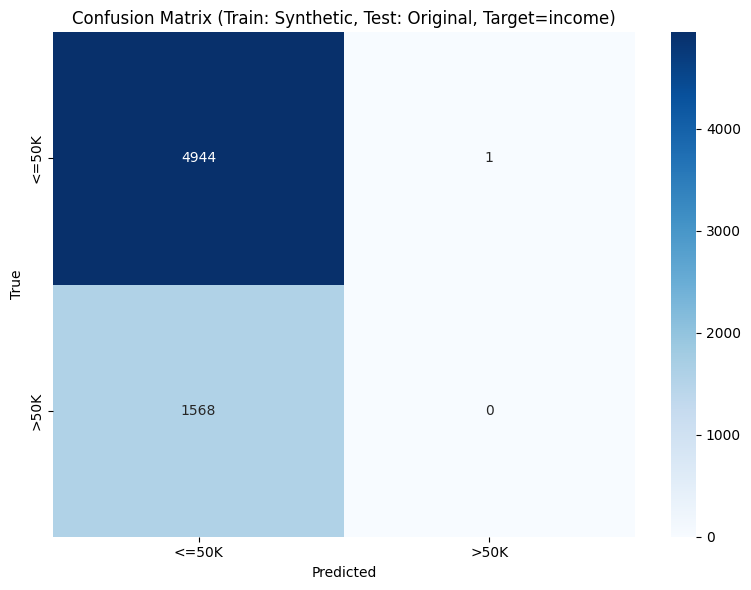

Saved ROC curve plot as 'roc_curve_synthetic_trained.png'


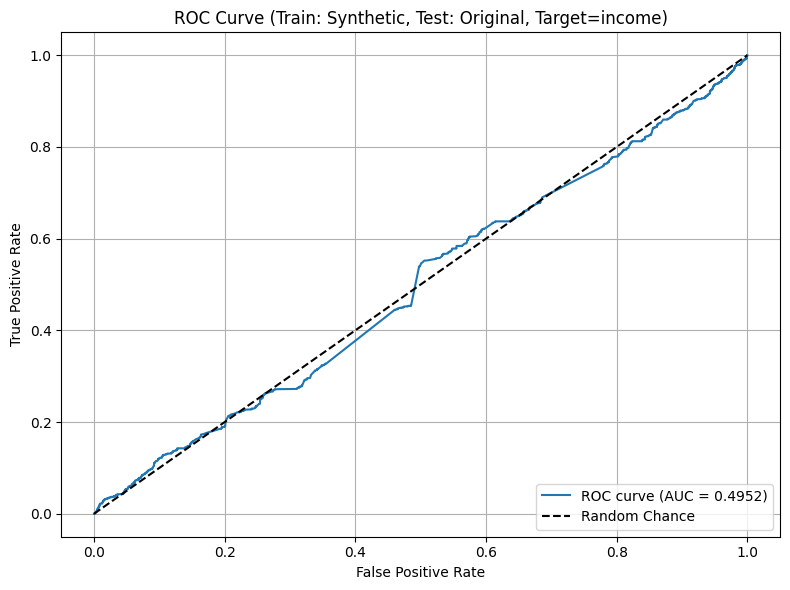


  Training on Original Data, Testing on Original Data (Baseline)...
  Accuracy (Train: Original, Test: Original): 0.8657
  Classification Report (Train: Original, Test: Original):
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      4945
        >50K       0.79      0.61      0.68      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.78      0.80      6513
weighted avg       0.86      0.87      0.86      6513

Saved confusion matrix plot as 'confusion_matrix_original_trained.png'


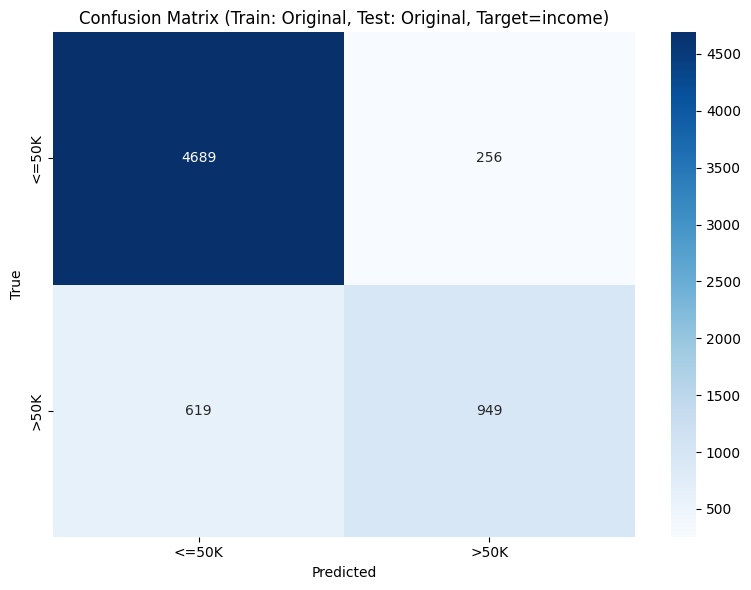

Saved ROC curve plot as 'roc_curve_original_trained.png'


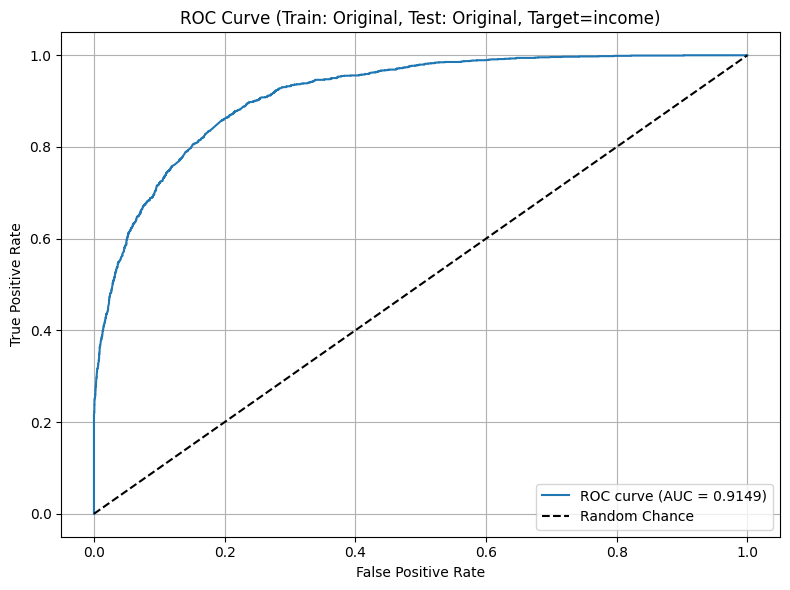


  ML Utility Comparison:
  Baseline Accuracy (Orig->Orig): 0.8657
  Synthetic Accuracy (Synth->Orig): 0.7591
  Accuracy Difference: 0.1066

--- Script Finished ---


In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings

warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    # Limit the number of marginals for practical reasons if k is large
    # Note: Original DPSyn might use all or a more sophisticated selection
    combs = combs[:min(len(combs), 10)] # Using a fixed limit for demonstration
    sensitivity = 1.0 # Sensitivity for counts in k-way marginals

    # Check if columns exist before proceeding
    valid_columns = [col for col in columns if col in data.columns]
    if not valid_columns:
         print("Error: No valid columns found in data for marginal generation.")
         return marginals

    # Recalculate combs based on valid columns present in the data
    combs = list(itertools.combinations(valid_columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)] # Re-limit based on valid combs

    if not combs:
        print(f"Warning: No valid combinations of size {k} found for the provided columns.")
        return marginals

    for comb in combs:
        try:
            # Ensure all columns in the combination exist in the DataFrame
            if all(c in data.columns for c in comb):
                counts = data[list(comb)].value_counts().to_dict()
                noisy_counts = {}
                for key, count in counts.items():
                    # Add Laplace noise for differential privacy
                    noise = np.random.laplace(0, sensitivity / epsilon)
                    noisy_counts[key] = max(0, count + noise) # Ensure counts are non-negative
                marginals[comb] = noisy_counts
            else:
                 print(f"Skipping marginal for {comb}: One or more columns not found in data.")
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent (simplified approach inspired by PriView/MST)
def make_consistent(marginals, data, columns):
    # Start with a copy of the original data structure but potentially empty or filled differently later
    # For this simplified version, we copy structure and will overwrite based on marginals
    synthetic_data = data.copy()

    # Iteratively adjust data based on noisy marginals
    # A full consistency algorithm is complex; this is a simplified sampling approach
    for comb, noisy_counts in marginals.items():
        try:
            total_noisy_count = sum(noisy_counts.values())
            if total_noisy_count == 0:
                # If the noisy marginal sums to zero, skip (or handle differently, e.g., uniform sampling)
                print(f"Warning: Noisy marginal for {comb} sums to zero. Skipping.")
                continue

            # Calculate probabilities from noisy counts
            probs = {k: v / total_noisy_count for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = list(probs.values())

            # Ensure probabilities sum to 1 (handle potential floating point issues)
            prob_values = np.array(prob_values)
            prob_values /= prob_values.sum()

            # Sample new values for the combination columns based on the noisy marginal distribution
            sample_size = len(data)
            # np.random.choice requires probabilities to sum to 1
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)

            # Update the synthetic data rows based on the sampled keys
            # This is a simplified update; real methods are more complex
            # This overwrites columns based on the *last* processed marginal containing them
            for i in range(sample_size):
                 sampled_key = keys[sampled_indices[i]]
                 # Ensure sampled_key is iterable and matches length of comb
                 if not isinstance(sampled_key, tuple):
                     sampled_key = (sampled_key,) # Make it a tuple if it's a single value count

                 if len(sampled_key) == len(comb):
                    for j, col in enumerate(comb):
                         if col in synthetic_data.columns: # Check if column exists
                             synthetic_data.at[i, col] = sampled_key[j]
                         else:
                             print(f"Warning: Column '{col}' from combination {comb} not found in synthetic_data during update.")
                 else:
                     print(f"Warning: Length mismatch between sampled key {sampled_key} and combination {comb}. Skipping update for row {i}.")


        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")

    return synthetic_data

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout() # Adjust layout
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        # Ensure y_pred_proba has scores for the positive class (usually index 1)
        if y_pred_proba.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
            try:
                 auc = roc_auc_score(y_true, y_pred_proba[:, 1])
                 plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
            except ValueError as e:
                 print(f"Error calculating AUC for binary case: {e}. Skipping plot.")
                 auc = float('nan') # Indicate AUC calculation failed
        else:
             print("Error: Expected 2 columns in y_pred_proba for binary classification.")
             return # Cannot plot if probabilities are incorrect
    else: # Multi-class case
        auc_scores = []
        all_fpr = []
        all_tpr = []
        for i in range(n_classes):
            # One-vs-Rest ROC curve for each class
            y_true_binary = (y_true == i).astype(int) # Binarize for the current class
            if np.sum(y_true_binary) > 0 and np.sum(y_true_binary) < len(y_true): # Check if class is present and not the only class
                 fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, i])
                 try:
                     auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                     plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
                     auc_scores.append(auc)
                     all_fpr.append(fpr)
                     all_tpr.append(tpr)
                 except ValueError as e:
                     print(f"Error calculating AUC for class {classes[i]}: {e}. Skipping this class.")
                     auc_scores.append(float('nan'))
            else:
                print(f"Skipping ROC for class {classes[i]} due to insufficient samples.")
                auc_scores.append(float('nan'))

        # Macro-average AUC (handle potential NaNs)
        valid_auc_scores = [s for s in auc_scores if not np.isnan(s)]
        if valid_auc_scores:
             auc_macro = np.mean(valid_auc_scores)
             plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.4f}')
        else:
            print("Could not calculate Macro-average AUC.")


    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Changed label for clarity
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout() # Adjust layout
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# --- Data Loading and Preprocessing ---
# Load HW1 dataset with correct column names
# IMPORTANT: Replace this path with the actual path to your 'adult.data' file
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.csv" # Use raw string for Windows path

adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

try:
    # Specify separator, handle spaces, indicate no header row
    data = pd.read_csv(data_path, names=adult_columns, sep=',\s*', header=None, engine='python', na_values='?')
    print("Dataset loaded successfully.")
    print(f"Initial dataset shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    print("Please update the 'data_path' variable with the correct location of 'adult.csv'.")
    exit(1)
except Exception as e:
    print(f"An error occurred loading the dataset: {e}")
    exit(1)


# Drop fnlwgt column as it's not typically used for these types of analyses
if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    # adult_columns.remove('fnlwgt') # Keep original list for reference if needed, get columns from df
    print("Dropped 'fnlwgt' column.")

# Handle missing values (replace NaN introduced by na_values='?' with a 'missing' string)
# Or consider imputation strategies if appropriate for your task
data = data.fillna('missing')
print(f"Dataset shape after handling missing values: {data.shape}")


# Verify and print columns after potential drop
columns = list(data.columns)
print("Dataset columns being used:", columns)

# Preprocess: Convert all columns to string type for consistent marginal calculation
# This simplifies handling mixed types but loses numerical properties for now
data = data.astype(str)
print("Converted all columns to string type for marginal processing.")


# --- Differential Privacy Parameters ---
epsilon_total = 1.0 # Total privacy budget
num_marginals = 10  # Number of k-way marginals to compute (using the limit from the function)
# Distribute epsilon equally among the selected marginals
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total
k_marginal = 2 # Dimension of marginals (e.g., 2-way)

print(f"\nStarting DPSyn process with:")
print(f"  Total epsilon: {epsilon_total}")
print(f"  Number of {k_marginal}-way marginals: {num_marginals}")
print(f"  Epsilon per marginal: {epsilon_per_marginal:.4f}")


# --- Generate Synthetic Data ---
# Step 1 & 2: Generate noisy marginals
print(f"\nStep 1&2: Generating {num_marginals} noisy {k_marginal}-way marginals...")
marginals = generate_noisy_marginals(data, columns, k=k_marginal, epsilon=epsilon_per_marginal)

# Step 3: Make marginals consistent and generate synthetic data
print("\nStep 3: Applying marginals to generate synthetic data...")
synthetic_data = make_consistent(marginals, data, columns)

# Save synthetic dataset
output_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv"
synthetic_data.to_csv(output_path, index=False)
print(f"\nSynthetic dataset generated and saved as '{output_path}'")
print(f"Synthetic dataset shape: {synthetic_data.shape}")


# --- Verification of Column Structure --- ADDED AS REQUESTED ---
print("\n--- Verifying Column Structure ---")
original_cols = list(data.columns)
synthetic_cols = list(synthetic_data.columns)

print("Original Data Columns:", original_cols)
print("Synthetic Data Columns:", synthetic_cols)

if original_cols == synthetic_cols:
    print("✅ Column names and order MATCH between original and synthetic data.")
else:
    print("⚠️ WARNING: Column names or order DIFFER between original and synthetic data.")
    # You could add more detailed comparison here if needed, e.g.:
    # print("Columns only in Original:", set(original_cols) - set(synthetic_cols))
    # print("Columns only in Synthetic:", set(synthetic_cols) - set(original_cols))

# --- End Verification ---


# --- Evaluation ---

# Evaluation: Total Variation Distance (TVD) for one-way marginals
def tvd(original_series, synthetic_series):
    """Calculates the Total Variation Distance between two categorical series."""
    try:
        # Ensure series are treated as strings/categorical for value_counts
        original_series = original_series.astype(str)
        synthetic_series = synthetic_series.astype(str)

        orig_counts = original_series.value_counts(normalize=True)
        synth_counts = synthetic_series.value_counts(normalize=True)

        # Combine indices to handle categories present in one series but not the other
        all_categories = orig_counts.index.union(synth_counts.index)

        # Reindex to ensure both series have the same categories, fill missing with 0
        orig_counts = orig_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)

        # Calculate TVD
        tvd_value = 0.5 * np.sum(np.abs(orig_counts - synth_counts))
        return tvd_value
    except Exception as e:
        print(f"Error computing TVD: {e}")
        return None

print("\n--- Evaluation: Utility Analysis ---")
print("1. Total Variation Distance (TVD) for selected 1-way marginals:")
tvd_results = {}
# Evaluate TVD for a few key categorical and the target columns
eval_columns = ['age', 'workclass', 'education', 'race', 'sex', 'income'] # Example columns

for col in eval_columns:
    if col in data.columns and col in synthetic_data.columns:
        tvd_value = tvd(data[col], synthetic_data[col])
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"  TVD for '{col}': {tvd_value:.4f}")
    else:
        print(f"  Skipping TVD for '{col}': Column not found in both datasets.")


# Evaluation: Classification accuracy using XGBoost
print("\n2. Machine Learning Utility (XGBoost Classification):")
# Use 'income' as target if available, otherwise fallback (e.g., 'marital-status')
if 'income' in data.columns and 'income' in synthetic_data.columns:
     target_column = 'income'
# elif 'marital-status' in data.columns and 'marital-status' in synthetic_data.columns:
#      target_column = 'marital-status' # Example fallback
else:
     target_column = None
     print("  'income' column not found in both datasets. Cannot perform classification task.")


if target_column:
    print(f"  Target variable: '{target_column}'")
    try:
        # Prepare data for classification
        # Original Data
        X_orig = data.drop(target_column, axis=1)
        y_orig = data[target_column]

        # Synthetic Data
        X_synth = synthetic_data.drop(target_column, axis=1)
        y_synth = synthetic_data[target_column]

        # --- Encoding ---
        # Encode target variable
        le = LabelEncoder()
        y_orig_encoded = le.fit_transform(y_orig)
        # Use the same encoder for synthetic data labels
        # Important: Handle potential new/missing labels in synthetic data if necessary
        # For simplicity, assume synthetic labels are a subset or match original for encoding
        y_synth_encoded = le.transform(y_synth)
        n_classes = len(le.classes_)
        print(f"  Encoded target classes: {le.classes_}")

        # Encode features using one-hot encoding
        # Align columns after encoding to handle potential differences in categories
        X_orig_encoded = pd.get_dummies(X_orig)
        X_synth_encoded = pd.get_dummies(X_synth)

        # Align columns: Keep only columns present in both, fill missing with 0
        common_cols = X_orig_encoded.columns.intersection(X_synth_encoded.columns)
        X_orig_aligned = X_orig_encoded[common_cols]
        X_synth_aligned = X_synth_encoded[common_cols]

        # Add missing columns (present in orig but not synth) to synth, fill with 0
        missing_in_synth = X_orig_aligned.columns.difference(X_synth_aligned.columns)
        for c in missing_in_synth:
            X_synth_aligned[c] = 0
        # Reorder synth columns to match original order
        X_synth_aligned = X_synth_aligned[X_orig_aligned.columns]

        print(f"  Data shape after encoding/alignment: X_orig={X_orig_aligned.shape}, X_synth={X_synth_aligned.shape}")


        # --- Train/Test Split ---
        # Split ORIGINAL data into train and test sets
        # We test models on real data (X_test, y_test)
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
            X_orig_aligned, y_orig_encoded, test_size=0.2, random_state=42, stratify=y_orig_encoded
        )
        print(f"  Split original data: Train={X_train_orig.shape}, Test={X_test_orig.shape}")

        # --- Model Training and Evaluation ---
        # Define XGBoost Classifier
        # Clean feature names for XGBoost (handles special characters)
        regex = re.compile(r"\[|\]|<", re.IGNORECASE)
        X_train_orig.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_orig.columns]
        X_test_orig.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_orig.columns]
        X_synth_aligned.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_synth_aligned.columns]


        clf = XGBClassifier(
            objective='binary:logistic' if n_classes == 2 else 'multi:softmax',
            eval_metric='logloss' if n_classes == 2 else 'mlogloss',
            use_label_encoder=False, # Recommended starting XGBoost 1.3.0
            random_state=42,
            n_estimators=100, # Number of boosting rounds
            max_depth=6,      # Maximum tree depth
            learning_rate=0.1 # Step size shrinkage
        )

        # Scenario 1: Train on SYNTHETIC data, Test on ORIGINAL data (TSTR)
        print("\n  Training on Synthetic Data, Testing on Original Data...")
        clf.fit(X_synth_aligned, y_synth_encoded)
        y_pred_synth_on_orig = clf.predict(X_test_orig)
        y_pred_proba_synth_on_orig = clf.predict_proba(X_test_orig)

        accuracy_synth = clf.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Synthetic, Test: Original): {accuracy_synth:.4f}")
        print("  Classification Report (Train: Synthetic, Test: Original):")
        print(classification_report(y_test_orig, y_pred_synth_on_orig, target_names=le.classes_))

        # Plot confusion matrix (Synthetic Trained)
        plot_confusion_matrix(
            y_test_orig, y_pred_synth_on_orig, le.classes_,
            f"Confusion Matrix (Train: Synthetic, Test: Original, Target={target_column})",
            "confusion_matrix_synthetic_trained.png"
        )

        # Plot ROC curve (Synthetic Trained)
        plot_roc_curve(
            y_test_orig, y_pred_proba_synth_on_orig, n_classes, le.classes_,
            f"ROC Curve (Train: Synthetic, Test: Original, Target={target_column})",
            "roc_curve_synthetic_trained.png"
        )


        # Scenario 2: Train on ORIGINAL data, Test on ORIGINAL data (Baseline)
        print("\n  Training on Original Data, Testing on Original Data (Baseline)...")
        clf.fit(X_train_orig, y_train_orig)
        y_pred_orig_on_orig = clf.predict(X_test_orig)
        y_pred_proba_orig_on_orig = clf.predict_proba(X_test_orig)

        accuracy_original = clf.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Original, Test: Original): {accuracy_original:.4f}")
        print("  Classification Report (Train: Original, Test: Original):")
        print(classification_report(y_test_orig, y_pred_orig_on_orig, target_names=le.classes_))

         # Plot confusion matrix (Original Trained)
        plot_confusion_matrix(
            y_test_orig, y_pred_orig_on_orig, le.classes_,
            f"Confusion Matrix (Train: Original, Test: Original, Target={target_column})",
            "confusion_matrix_original_trained.png"
        )

        # Plot ROC curve (Original Trained)
        plot_roc_curve(
            y_test_orig, y_pred_proba_orig_on_orig, n_classes, le.classes_,
            f"ROC Curve (Train: Original, Test: Original, Target={target_column})",
            "roc_curve_original_trained.png"
        )

        # Compare Results
        print("\n  ML Utility Comparison:")
        print(f"  Baseline Accuracy (Orig->Orig): {accuracy_original:.4f}")
        print(f"  Synthetic Accuracy (Synth->Orig): {accuracy_synth:.4f}")
        print(f"  Accuracy Difference: {accuracy_original - accuracy_synth:.4f}")


    except Exception as e:
        import traceback
        print(f"Error during classification evaluation: {e}")
        print(traceback.format_exc()) # Print detailed traceback

print("\n--- Script Finished ---")

In [31]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC  # Import SVM
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings

warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]
    sensitivity = 1.0

    valid_columns = [col for col in columns if col in data.columns]
    if not valid_columns:
        print("Error: No valid columns found in data for marginal generation.")
        return marginals

    combs = list(itertools.combinations(valid_columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]

    if not combs:
        print(f"Warning: No valid combinations of size {k} found for the provided columns.")
        return marginals

    for comb in combs:
        try:
            if all(c in data.columns for c in comb):
                counts = data[list(comb)].value_counts().to_dict()
                noisy_counts = {}
                for key, count in counts.items():
                    noise = np.random.laplace(0, sensitivity / epsilon)
                    noisy_counts[key] = max(0, count + noise)
                marginals[comb] = noisy_counts
            else:
                print(f"Skipping marginal for {comb}: One or more columns not found in data.")
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent
def make_consistent(marginals, data, columns):
    synthetic_data = data.copy()
    for comb, noisy_counts in marginals.items():
        try:
            total_noisy_count = sum(noisy_counts.values())
            if total_noisy_count == 0:
                print(f"Warning: Noisy marginal for {comb} sums to zero. Skipping.")
                continue

            probs = {k: v / total_noisy_count for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = list(probs.values())

            prob_values = np.array(prob_values)
            prob_values /= prob_values.sum()

            sample_size = len(data)
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)

            for i in range(sample_size):
                sampled_key = keys[sampled_indices[i]]
                if not isinstance(sampled_key, tuple):
                    sampled_key = (sampled_key,)

                if len(sampled_key) == len(comb):
                    for j, col in enumerate(comb):
                        if col in synthetic_data.columns:
                            synthetic_data.at[i, col] = sampled_key[j]
                        else:
                            print(f"Warning: Column '{col}' from combination {comb} not found in synthetic_data during update.")
                else:
                    print(f"Warning: Length mismatch between sampled key {sampled_key} and combination {comb}. Skipping update for row {i}.")
        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")

    return synthetic_data

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        if y_pred_proba.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
            try:
                auc = roc_auc_score(y_true, y_pred_proba[:, 1])
                plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
            except ValueError as e:
                print(f"Error calculating AUC for binary case: {e}. Skipping plot.")
                auc = float('nan')
        else:
            print("Error: Expected 2 columns in y_pred_proba for binary classification.")
            return
    else:
        auc_scores = []
        all_fpr = []
        all_tpr = []
        for i in range(n_classes):
            y_true_binary = (y_true == i).astype(int)
            if np.sum(y_true_binary) > 0 and np.sum(y_true_binary) < len(y_true):
                fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, i])
                try:
                    auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
                    auc_scores.append(auc)
                    all_fpr.append(fpr)
                    all_tpr.append(tpr)
                except ValueError as e:
                    print(f"Error calculating AUC for class {classes[i]}: {e}. Skipping this class.")
                    auc_scores.append(float('nan'))
            else:
                print(f"Skipping ROC for class {classes[i]} due to insufficient samples.")
                auc_scores.append(float('nan'))

        valid_auc_scores = [s for s in auc_scores if not np.isnan(s)]
        if valid_auc_scores:
            auc_macro = np.mean(valid_auc_scores)
            plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.4f}')
        else:
            print("Could not calculate Macro-average AUC.")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# --- Data Loading and Preprocessing ---
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.csv"
adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

try:
    data = pd.read_csv(data_path, names=adult_columns, sep=',\s*', header=None, engine='python', na_values='?')
    print("Dataset loaded successfully.")
    print(f"Initial dataset shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    print("Please update the 'data_path' variable with the correct location of 'adult.csv'.")
    exit(1)
except Exception as e:
    print(f"An error occurred loading the dataset: {e}")
    exit(1)

if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    print("Dropped 'fnlwgt' column.")

data = data.fillna('missing')
print(f"Dataset shape after handling missing values: {data.shape}")

columns = list(data.columns)
print("Dataset columns being used:", columns)

data = data.astype(str)
print("Converted all columns to string type for marginal processing.")

# --- Differential Privacy Parameters ---
epsilon_total = 1.0
num_marginals = 10
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total
k_marginal = 2

print(f"\nStarting DPSyn process with:")
print(f"  Total epsilon: {epsilon_total}")
print(f"  Number of {k_marginal}-way marginals: {num_marginals}")
print(f"  Epsilon per marginal: {epsilon_per_marginal:.4f}")

# --- Generate Synthetic Data ---
print(f"\nStep 1&2: Generating {num_marginals} noisy {k_marginal}-way marginals...")
marginals = generate_noisy_marginals(data, columns, k=k_marginal, epsilon=epsilon_per_marginal)

print("\nStep 3: Applying marginals to generate synthetic data...")
synthetic_data = make_consistent(marginals, data, columns)

output_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv"
synthetic_data.to_csv(output_path, index=False)
print(f"\nSynthetic dataset generated and saved as '{output_path}'")
print(f"Synthetic dataset shape: {synthetic_data.shape}")

# --- Verification of Column Structure ---
print("\n--- Verifying Column Structure ---")
original_cols = list(data.columns)
synthetic_cols = list(synthetic_data.columns)

print("Original Data Columns:", original_cols)
print("Synthetic Data Columns:", synthetic_cols)

if original_cols == synthetic_cols:
    print("✅ Column names and order MATCH between original and synthetic data.")
else:
    print("⚠️ WARNING: Column names or order DIFFER between original and synthetic data.")

# --- Evaluation ---

def tvd(original_series, synthetic_series):
    """Calculates the Total Variation Distance between two categorical series."""
    try:
        original_series = original_series.astype(str)
        synthetic_series = synthetic_series.astype(str)

        orig_counts = original_series.value_counts(normalize=True)
        synth_counts = synthetic_series.value_counts(normalize=True)

        all_categories = orig_counts.index.union(synth_counts.index)

        orig_counts = orig_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)

        tvd_value = 0.5 * np.sum(np.abs(orig_counts - synth_counts))
        return tvd_value
    except Exception as e:
        print(f"Error computing TVD: {e}")
        return None

print("\n--- Evaluation: Utility Analysis ---")
print("1. Total Variation Distance (TVD) for selected 1-way marginals:")
tvd_results = {}
eval_columns = ['age', 'workclass', 'education', 'race', 'sex', 'income']

for col in eval_columns:
    if col in data.columns and col in synthetic_data.columns:
        tvd_value = tvd(data[col], synthetic_data[col])
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"  TVD for '{col}': {tvd_value:.4f}")
    else:
        print(f"  Skipping TVD for '{col}': Column not found in both datasets.")

print("\n2. Machine Learning Utility (XGBoost and SVM Classification):")
if 'income' in data.columns and 'income' in synthetic_data.columns:
    target_column = 'income'
else:
    target_column = None
    print("  'income' column not found in both datasets. Cannot perform classification task.")

if target_column:
    print(f"  Target variable: '{target_column}'")
    try:
        X_orig = data.drop(target_column, axis=1)
        y_orig = data[target_column]
        X_synth = synthetic_data.drop(target_column, axis=1)
        y_synth = synthetic_data[target_column]

        le = LabelEncoder()
        y_orig_encoded = le.fit_transform(y_orig)
        y_synth_encoded = le.transform(y_synth)
        n_classes = len(le.classes_)
        print(f"  Encoded target classes: {le.classes_}")

        X_orig_encoded = pd.get_dummies(X_orig)
        X_synth_encoded = pd.get_dummies(X_synth)

        common_cols = X_orig_encoded.columns.intersection(X_synth_encoded.columns)
        X_orig_aligned = X_orig_encoded[common_cols]
        X_synth_aligned = X_synth_encoded[common_cols]

        missing_in_synth = X_orig_aligned.columns.difference(X_synth_aligned.columns)
        for c in missing_in_synth:
            X_synth_aligned[c] = 0
        X_synth_aligned = X_synth_aligned[X_orig_aligned.columns]

        print(f"  Data shape after encoding/alignment: X_orig={X_orig_aligned.shape}, X_synth={X_synth_aligned.shape}")

        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
            X_orig_aligned, y_orig_encoded, test_size=0.2, random_state=42, stratify=y_orig_encoded
        )
        print(f"  Split original data: Train={X_train_orig.shape}, Test={X_test_orig.shape}")

        regex = re.compile(r"[|]|<", re.IGNORECASE)
        X_train_orig.columns = [regex.sub("_", col) for col in X_train_orig.columns]
        X_test_orig.columns = [regex.sub("_", col) for col in X_test_orig.columns]
        X_synth_aligned.columns = [regex.sub("_", col) for col in X_synth_aligned.columns]

        # Scenario 1: Train on SYNTHETIC data, Test on ORIGINAL data (TSTR)
        print("\n  Training on Synthetic Data, Testing on Original Data with XGBoost...")
        clf_xgb = XGBClassifier(
            objective='binary:logistic' if n_classes == 2 else 'multi:softmax',
            eval_metric='logloss' if n_classes == 2 else 'mlogloss',
            use_label_encoder=False,
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1
        )
        clf_xgb.fit(X_synth_aligned, y_synth_encoded)
        y_pred_synth_on_orig = clf_xgb.predict(X_test_orig)
        y_pred_proba_synth_on_orig = clf_xgb.predict_proba(X_test_orig)

        accuracy_synth = clf_xgb.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Synthetic, Test: Original with XGBoost): {accuracy_synth:.4f}")
        print("  Classification Report (Train: Synthetic, Test: Original with XGBoost):")
        print(classification_report(y_test_orig, y_pred_synth_on_orig, target_names=le.classes_))

        # Scenario 2: Train on ORIGINAL data, Test on ORIGINAL data with XGBoost
        print("\n  Training on Original Data, Testing on Original Data with XGBoost...")
        clf_xgb.fit(X_train_orig, y_train_orig)
        y_pred_orig_on_orig = clf_xgb.predict(X_test_orig)
        y_pred_proba_orig_on_orig = clf_xgb.predict_proba(X_test_orig)

        accuracy_original = clf_xgb.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Original, Test: Original with XGBoost): {accuracy_original:.4f}")
        print("  Classification Report (Train: Original, Test: Original with XGBoost):")
        print(classification_report(y_test_orig, y_pred_orig_on_orig, target_names=le.classes_))

        # --- Adding SVM Evaluation ---
        print("\n  Training on Synthetic Data, Testing on Original Data with SVM...")
        clf_svm = SVC(probability=True, random_state=42)  # SVM classifier
        clf_svm.fit(X_synth_aligned, y_synth_encoded)
        y_pred_svm_synth_on_orig = clf_svm.predict(X_test_orig)
        y_pred_proba_svm_synth_on_orig = clf_svm.predict_proba(X_test_orig)

        accuracy_svm_synth = clf_svm.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Synthetic, Test: Original with SVM): {accuracy_svm_synth:.4f}")
        print("  Classification Report (Train: Synthetic, Test: Original with SVM):")
        print(classification_report(y_test_orig, y_pred_svm_synth_on_orig, target_names=le.classes_))

        # Scenario 2: Train on ORIGINAL data, Test on ORIGINAL data with SVM
        print("\n  Training on Original Data, Testing on Original Data with SVM...")
        clf_svm.fit(X_train_orig, y_train_orig)
        y_pred_svm_orig_on_orig = clf_svm.predict(X_test_orig)
        y_pred_proba_svm_orig_on_orig = clf_svm.predict_proba(X_test_orig)

        accuracy_svm_original = clf_svm.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Original, Test: Original with SVM): {accuracy_svm_original:.4f}")
        print("  Classification Report (Train: Original, Test: Original with SVM):")
        print(classification_report(y_test_orig, y_pred_svm_orig_on_orig, target_names=le.classes_))

        # Compare Results
        print("\n  ML Utility Comparison:")
        print(f"  Baseline Accuracy (Orig->Orig with XGBoost): {accuracy_original:.4f}")
        print(f"  Synthetic Accuracy (Synth->Orig with XGBoost): {accuracy_synth:.4f}")
        print(f"  Accuracy Difference (XGBoost): {accuracy_original - accuracy_synth:.4f}")

        print(f"  Baseline Accuracy (Orig->Orig with SVM): {accuracy_svm_original:.4f}")
        print(f"  Synthetic Accuracy (Synth->Orig with SVM): {accuracy_svm_synth:.4f}")
        print(f"  Accuracy Difference (SVM): {accuracy_svm_original - accuracy_svm_synth:.4f}")

    except Exception as e:
        import traceback
        print(f"Error during classification evaluation: {e}")
        print(traceback.format_exc())

print("\n--- Script Finished ---")

Dataset loaded successfully.
Initial dataset shape: (32561, 15)
Dropped 'fnlwgt' column.
Dataset shape after handling missing values: (32561, 14)
Dataset columns being used: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Converted all columns to string type for marginal processing.

Starting DPSyn process with:
  Total epsilon: 1.0
  Number of 2-way marginals: 10
  Epsilon per marginal: 0.1000

Step 1&2: Generating 10 noisy 2-way marginals...

Step 3: Applying marginals to generate synthetic data...

Synthetic dataset generated and saved as 'c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv'
Synthetic dataset shape: (32561, 14)

--- Verifying Column Structure ---
Original Data Columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital

In [39]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings
import os  # Added for handling file paths
warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]
    sensitivity = 1.0
    for comb in combs:
        try:
            counts = data[list(comb)].value_counts().to_dict()
            noisy_counts = {}
            for key, count in counts.items():
                noise = np.random.laplace(0, sensitivity / epsilon)
                noisy_counts[key] = max(0, count + noise)
            marginals[comb] = noisy_counts
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent (simplified PriView)
def make_consistent(marginals, data, columns):
    synthetic_data = data.copy()
    for comb, noisy_counts in marginals.items():
        try:
            total = sum(noisy_counts.values())
            if total == 0:
                continue
            probs = {k: v / total for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = [probs[k] for k in keys]
            sample_size = len(data)
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)
            sampled_keys = [keys[i] for i in sampled_indices]
            for i, key in enumerate(sampled_keys):
                for j, col in enumerate(comb):
                    synthetic_data.at[i, col] = key[j]
        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")
    return synthetic_data

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    else:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, i], pos_label=i)
            auc = roc_auc_score(y_true == i, y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
        # Macro-average AUC
        auc_macro = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.brand}')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# Load HW1 dataset with correct column names
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.data"
adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
try:
    data = pd.read_csv(data_path, names=adult_columns,na_values="?", skiprows=0)
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    exit(1)

# Drop fnlwgt column
if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    adult_columns.remove('fnlwgt')

# Verify and print columns
columns = data.columns
print("Dataset columns:", list(columns))

# Preprocess: Handle k-anonymized data
data = data.fillna('missing')
data = data.astype(str)

# Parameters
epsilon_total = 1.0
num_marginals = 10
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total

# Step 1 & 2: Generate noisy marginals
marginals = generate_noisy_marginals(data, columns, k=2, epsilon=epsilon_per_marginal)

# Step 3: Make marginals consistent and generate synthetic data
synthetic_data = make_consistent(marginals, data, columns)

# Save synthetic dataset
output_dir = os.path.dirname(data_path)  # Get the directory of the input file
output_path = os.path.join(output_dir, "synthetic_anonymized_adult.csv")  # Construct full path
synthetic_data.to_csv(output_path, index=False)
print(f"Synthetic dataset saved as '{output_path}'")

# Evaluation: Total Variation Distance (TVD)
def tvd(original, synthetic, column):
    try:
        orig_counts = original[column].value_counts(normalize=True)
        synth_counts = synthetic[column].value_counts(normalize=True)
        common_idx = orig_counts.index.intersection(synth_counts.index)
        return 0.5 * np.sum(np.abs(orig_counts[common_idx] - synth_counts[common_idx]))
    except Exception as e:
        print(f"Error computing TVD for {column}: {e}")
        return None

# Compute TVD for selected columns
tvd_results = {}
eval_columns = ['age', 'workclass', 'occupation', 'relationship', 'race','capital-gain', 'capital-loss']
for col in eval_columns:
    if col in columns:
        tvd_value = tvd(data, synthetic_data, col)
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"TVD for {col}: {tvd_value:.4f}")

# Evaluation: Classification accuracy with XGBoost
target_column = 'income' if 'income' in columns else 'marital-status'
if target_column:
    try:
        X = data.drop(target_column, axis=1)
        y = data[target_column]
        X_synthetic = synthetic_data.drop(target_column, axis=1)
        y_synthetic = synthetic_data[target_column]

        # Encode categorical variables
        le = LabelEncoder()
        y = le.fit_transform(y)
        y_synthetic = le.transform(y_synthetic)
        X = pd.get_dummies(X)
        X_synthetic = pd.get_dummies(X_synthetic)

        # Clean feature names for XGBoost
        X.columns = [re.sub(r'[<>$$  $$,]', '_', col) for col in X.columns]
        X_synthetic = X_synthetic.reindex(columns=X.columns, fill_value=0)

        # Split original data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train on synthetic data, test on original
        clf = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary:logistic' if data[target_column].nunique() == 2 else 'multi:softmax',
            eval_metric='logloss' if data[target_column].nunique() == 2 else 'mlogloss',
            random_state=42
        )
        clf.fit(X_synthetic, y_synthetic)
        y_pred_synthetic = clf.predict(X_test)
        accuracy_synthetic = clf.score(X_test, y_test)
        print(f"Classification accuracy (synthetic data, target={target_column}, XGBoost): {accuracy_synthetic:.4f}")
        print("\nClassification Report (synthetic data):")
        print(classification_report(y_test, y_pred_synthetic, target_names=le.classes_))
        
        # Plot confusion matrix for synthetic data
        plot_confusion_matrix(
            y_test, y_pred_synthetic, le.classes_,
            "Confusion Matrix (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_synthetic.png"
        )

        # Plot ROC curve for synthetic data
        y_pred_proba_synthetic = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_synthetic, data[target_column].nunique(), le.classes_,
            "ROC Curve (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_synthetic.png"
        )

        # Baseline: Train and test on original
        clf.fit(X_train, y_train)
        y_pred_original = clf.predict(X_test)
        accuracy_original = clf.score(X_test, y_test)
        print(f"\nClassification accuracy (original data, target={target_column}, XGBoost): {accuracy_original:.4f}")
        print("\nClassification Report (original data):")
        print(classification_report(y_test, y_pred_original, target_names=le.classes_))
        
        # Plot confusion matrix for original data
        plot_confusion_matrix(
            y_test, y_pred_original, le.classes_,
            "Confusion Matrix (Original Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_original.png"
        )

        # Plot ROC curve for original data
        y_pred_proba_original = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_original, data[target_column].nunique(), le.classes_,
            "ROC Curve (Original Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_original.png"
        )

    except Exception as e:
        print(f"Error in classification evaluation: {e}")
else:
    print("No suitable target column found for classification.")

Dataset columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Synthetic dataset saved as 'c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv'
TVD for age: 0.3239
TVD for workclass: 0.0000
TVD for occupation: 0.0000
TVD for relationship: 0.0000
TVD for race: 0.0000
TVD for capital-gain: 0.0000
TVD for capital-loss: 0.0000
Error in classification evaluation: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.


In [63]:
columns = ["age", "workclass",  "education", "education-num", "marital-status",
          "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]


data = pd.read_csv(
	r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv",
		na_values="?",
	skipinitialspace=True)

#data = data.drop(data.columns[0], axis=1)
data.head()


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,22,Private,10th,6,Never-married,Craft-repair,Not-in-family,White,Male,0,0,16,United-States,<=50K
1,24,Private,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,>50K
2,36,Self-emp-not-inc,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,36,United-States,<=50K
3,41,Private,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,<=50K
4,37,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,NaN,<=50K


In [65]:
column = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data_original = pd.read_csv(
    r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.csv", 
    names=column, 
    skipinitialspace=True,
    index_col=None
)
data_original=data_original.drop('fnlwgt', axis=1)
data_original.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [53]:
print(data.columns)

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income'],
      dtype='object')


In [54]:
data.reset_index(drop=True, inplace=True)

In [69]:
from scipy.stats import chi2_contingency

# Create contingency tables
contingency_table_original = pd.crosstab(data_original['workclass'], data_original['workclass'])
contingency_table_synthetic = pd.crosstab(data['workclass'], data['workclass'])

# Combine the two tables
combined_table = contingency_table_original.add(contingency_table_synthetic, fill_value=0)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(combined_table)

# Output the results
print("Chi-square Statistic:", chi2)
print("p-value:", p)

Chi-square Statistic: 506752.0
p-value: 0.0


Dataset columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Synthetic dataset saved as 'c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv'
Density Estimation Score: 103.57
TVD for age: 0.3216
KLD for age: -0.2761
TVD for workclass: 0.0000
KLD for workclass: 0.0000
TVD for occupation: 0.0000
KLD for occupation: 0.0000
TVD for relationship: 0.0000
KLD for relationship: 0.0000
TVD for race: 0.0000
KLD for race: 0.0000
TVD for capital-gain: 0.0000
KLD for capital-gain: 0.0000
TVD for capital-loss: 0.0000
KLD for capital-loss: 0.0000


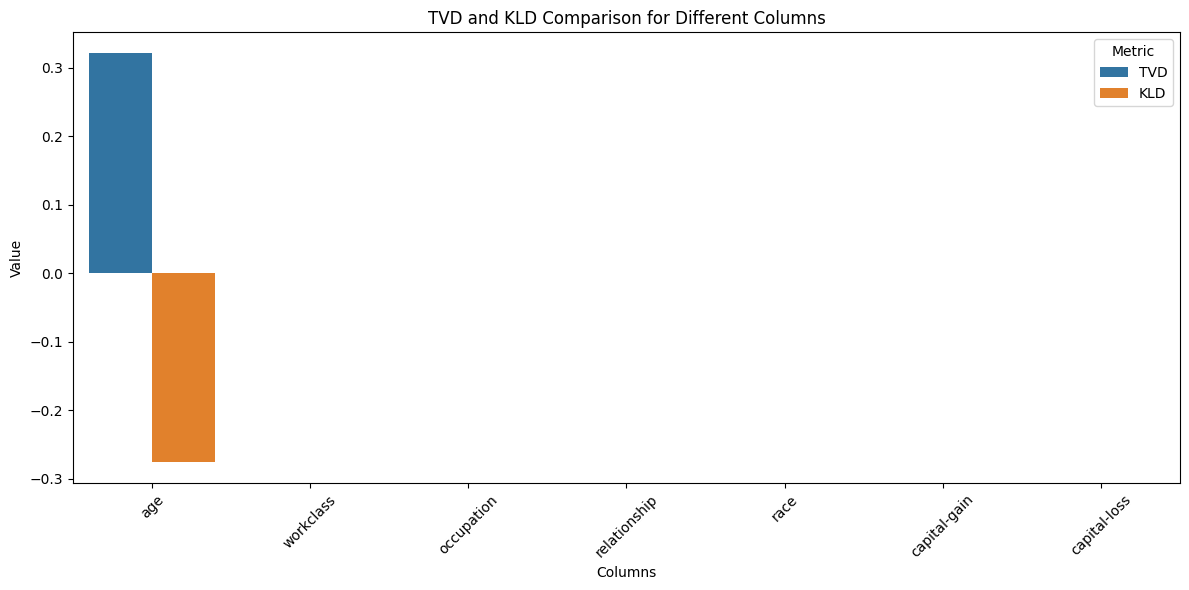

Error in classification evaluation: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.


In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings
import os  # Added for handling file paths
warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]
    sensitivity = 1.0
    for comb in combs:
        try:
            counts = data[list(comb)].value_counts().to_dict()
            noisy_counts = {}
            for key, count in counts.items():
                noise = np.random.laplace(0, sensitivity / epsilon)
                noisy_counts[key] = max(0, count + noise)
            marginals[comb] = noisy_counts
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent (simplified PriView)
def make_consistent(marginals, data, columns):
    synthetic_data = data.copy()
    for comb, noisy_counts in marginals.items():
        try:
            total = sum(noisy_counts.values())
            if total == 0:
                continue
            probs = {k: v / total for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = [probs[k] for k in keys]
            sample_size = len(data)
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)
            sampled_keys = [keys[i] for i in sampled_indices]
            for i, key in enumerate(sampled_keys):
                for j, col in enumerate(comb):
                    synthetic_data.at[i, col] = key[j]
        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")
    return synthetic_data

# Density Estimation Metric
def density_estimation(original, synthetic, columns):
    total_penalty = 0
    for col in columns:
        orig_counts = original[col].value_counts(normalize=True)
        synth_counts = synthetic[col].value_counts(normalize=True)
        common_idx = orig_counts.index.intersection(synth_counts.index)
        orig_normalized = orig_counts[common_idx]
        synth_normalized = synth_counts[common_idx]
        penalty = np.sum(np.abs(orig_normalized - synth_normalized))  # L1 distance
        total_penalty += penalty
    # Score transformation
    score = 106 * (1 - total_penalty / (len(columns) * 2))  # Scale score
    return max(0, min(score, 106))  # Ensure score is between 0 and 106

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    else:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, i], pos_label=i)
            auc = roc_auc_score(y_true == i, y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
        # Macro-average AUC
        auc_macro = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.4f}')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# Load HW1 dataset with correct column names
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.data"
adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
try:
    data = pd.read_csv(data_path, names=adult_columns, na_values="?", skiprows=0)
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    exit(1)

# Drop fnlwgt column
if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    adult_columns.remove('fnlwgt')

# Verify and print columns
columns = data.columns
print("Dataset columns:", list(columns))

# Preprocess: Handle k-anonymized data
data = data.fillna('missing')
data = data.astype(str)

# Parameters
epsilon_total = 1.0
num_marginals = 10
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total

# Step 1 & 2: Generate noisy marginals
marginals = generate_noisy_marginals(data, columns, k=2, epsilon=epsilon_per_marginal)

# Step 3: Make marginals consistent and generate synthetic data
synthetic_data = make_consistent(marginals, data, columns)

# Save synthetic dataset
output_dir = os.path.dirname(data_path)  # Get the directory of the input file
output_path = os.path.join(output_dir, "synthetic_anonymized_adult.csv")  # Construct full path
synthetic_data.to_csv(output_path, index=False)
print(f"Synthetic dataset saved as '{output_path}'")

# Evaluate Density Estimation
density_score = density_estimation(data, synthetic_data, columns)
print(f"Density Estimation Score: {density_score:.2f}")

# Evaluation: Total Variation Distance (TVD)
def tvd(original, synthetic, column):
    try:
        orig_counts = original[column].value_counts(normalize=True)
        synth_counts = synthetic[column].value_counts(normalize=True)
        common_idx = orig_counts.index.intersection(synth_counts.index)
        return 0.5 * np.sum(np.abs(orig_counts[common_idx] - synth_counts[common_idx]))
    except Exception as e:
        print(f"Error computing TVD for {column}: {e}")
        return None

# Evaluation: Kullback-Leibler Divergence (KLD)
def kullback_leibler_divergence(original, synthetic, column):
    try:
        orig_counts = original[column].value_counts(normalize=True)
        synth_counts = synthetic[column].value_counts(normalize=True)
        common_idx = orig_counts.index.intersection(synth_counts.index)
        kld = np.sum(orig_counts[common_idx] * np.log(orig_counts[common_idx] / synth_counts[common_idx] + 1e-10))  # Adding epsilon to avoid log(0)
        return kld
    except Exception as e:
        print(f"Error computing KLD for {column}: {e}")
        return None

# Compute TVD and KLD for selected columns
tvd_results = {}
kld_results = {}
eval_columns = ['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
for col in eval_columns:
    if col in columns:
        tvd_value = tvd(data, synthetic_data, col)
        kld_value = kullback_leibler_divergence(data, synthetic_data, col)
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"TVD for {col}: {tvd_value:.4f}")
        if kld_value is not None:
            kld_results[col] = kld_value
            print(f"KLD for {col}: {kld_value:.4f}")

# Visualization of TVD and KLD results
def plot_metrics(tvd_results, kld_results):
    metrics_df = pd.DataFrame({
        'Column': list(tvd_results.keys()),
        'TVD': list(tvd_results.values()),
        'KLD': list(kld_results.values())
    })

    metrics_df = metrics_df.melt(id_vars='Column', var_name='Metric', value_name='Value')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='Column', y='Value', hue='Metric')
    plt.title('TVD and KLD Comparison for Different Columns')
    plt.xlabel('Columns')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig('tvd_kld_comparison.png')
    plt.show()

# Call the plotting function
plot_metrics(tvd_results, kld_results)

# Evaluation: Classification accuracy with XGBoost
target_column = 'income' if 'income' in columns else 'marital-status'
if target_column:
    try:
        X = data.drop(target_column, axis=1)
        y = data[target_column]
        X_synthetic = synthetic_data.drop(target_column, axis=1)
        y_synthetic = synthetic_data[target_column]

        # Encode categorical variables
        le = LabelEncoder()
        y = le.fit_transform(y)
        y_synthetic = le.transform(y_synthetic)
        X = pd.get_dummies(X)
        X_synthetic = pd.get_dummies(X_synthetic)

        # Clean feature names for XGBoost
        X.columns = [re.sub(r'[<>$$  $$,]', '_', col) for col in X.columns]
        X_synthetic = X_synthetic.reindex(columns=X.columns, fill_value=0)

        # Split original data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train on synthetic data, test on original
        clf = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary:logistic' if data[target_column].nunique() == 2 else 'multi:softmax',
            eval_metric='logloss' if data[target_column].nunique() == 2 else 'mlogloss',
            random_state=42
        )
        clf.fit(X_synthetic, y_synthetic)
        y_pred_synthetic = clf.predict(X_test)
        accuracy_synthetic = clf.score(X_test, y_test)
        print(f"Classification accuracy (synthetic data, target={target_column}, XGBoost): {accuracy_synthetic:.4f}")
        print("\nClassification Report (synthetic data):")
        print(classification_report(y_test, y_pred_synthetic, target_names=le.classes_))
        
        # Plot confusion matrix for synthetic data
        plot_confusion_matrix(
            y_test, y_pred_synthetic, le.classes_,
            "Confusion Matrix (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_synthetic.png"
        )

        # Plot ROC curve for synthetic data
        y_pred_proba_synthetic = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_synthetic, data[target_column].nunique(), le.classes_,
            "ROC Curve (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_synthetic.png"
        )

        # Baseline: Train and test on original
        clf.fit(X_train, y_train)
        y_pred_original = clf.predict(X_test)
        accuracy_original = clf.score(X_test, y_test)
        print(f"\nClassification accuracy (original data, target={target_column}, XGBoost): {accuracy_original:.4f}")
        print("\nClassification Report (original data):")
        print(classification_report(y_test, y_pred_original, target_names=le.classes_))
        
        # Plot confusion matrix for original data
        plot_confusion_matrix(
            y_test, y_pred_original, le.classes_,
            "Confusion Matrix (Original Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_original.png"
        )

        # Plot ROC curve for original data
        y_pred_proba_original = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_original, data[target_column].nunique(), le.classes_,
            "ROC Curve (Original Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_original.png"
        )

    except Exception as e:
        print(f"Error in classification evaluation: {e}")
else:
    print("No suitable target column found for classification.")